# Extended Streamflow Prediction forecasts from climatological time series

This notebook shows how to perform a climatological Extended Streamflow Prediction (ESP) forecast, using historical weather as a proxy for future weather.

The general idea is to initialize the state of the hydrological model to represent current conditions, but instead of using weather forecasts to predict future flows, we run the model with observed, historical weather series from past years. So for example if we have 30 years of weather observations, we get 30 different forecasts. The accuracy of this forecast ensemble can then be evaluated by different probabilistic metrics.

## Run the model simulations

Here we set model parameters somewhat arbitrarily, specify the start date for the climatological ESP simulations and run the simulations.

In [ ]:
# Define some of the catchment properties. Could also be replaced by a call to the properties WPS.
import datetime as dt
from ravenpy.utilities import forecasting
from ravenpy.utilities.testdata import get_file
from ravenpy.models import HRU, GR4JCN

hru = GR4JCN.LandHRU(area=4523.5, longitude=-72.55, latitude=48.39, elevation=300.0)

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE', 'HBVEC' and 'BLENDED'.
hydromodel = 'GR4JCN'

# Since we've used GR4JCN, we need to provide that model's parameters.
model_parameters = (0.529, -3.396, 407.29, 1.072, 16.9, 0.947)

# Choose the forecast date. Each forecast will start with the same day and month.
# For example, jan-05-2001 will compare the climatology using all jan-05ths from the dataset)
fdate = dt.datetime(2005, 9, 13)

# The dataset to use to get the forecast timeseries:
ts = get_file("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc")

duration = 30  # Length in days of the climatological ESP forecast

# Launch the climatology ESP on the remote server
qsims = forecasting.perform_climatology_esp(model_name="GR4JCN",
                                            forecast_date=dt.datetime(2005, 9, 13), 
                                            forecast_duration=30,
                                            params=model_parameters,
                                            hrus=[hru,],
                                            ts=ts,
                                            name="Salmon_ESP")

/home/david/.conda/envs/ravenpy/lib/python3.8/zipfile.py:1517: UserWarning: Duplicate name: 'raven-gr4j-cemaneige.rvp'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/david/.conda/envs/ravenpy/lib/python3.8/zipfile.py:1517: UserWarning: Duplicate name: 'raven-gr4j-cemaneige.rvh'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/david/.conda/envs/ravenpy/lib/python3.8/zipfile.py:1517: UserWarning: Duplicate name: 'raven-gr4j-cemaneige.rvt'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/david/.conda/envs/ravenpy/lib/python3.8/zipfile.py:1517: UserWarning: Duplicate name: 'raven-gr4j-cemaneige.rvc'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/david/.conda/envs/ravenpy/lib/python3.8/zipfile.py:1517: UserWarning: Duplicate name: 'raven-gr4j-cemaneige.rvi'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


We can now inspect and graph the results.

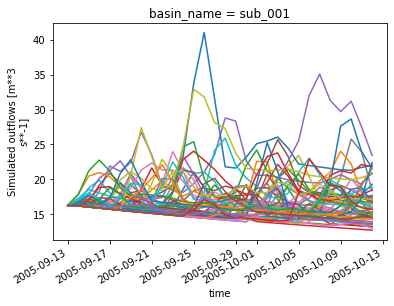

In [ ]:
fig = qsims.plot(hue="member", add_legend=False)

## Compute the forecast scores

There are different metric to evaluate the performance of forecasts. As an example, here we are computing the CRPS metric, using the [xskillscore](https://xskillscore.readthedocs.io/en/stable/) library server-side.

In [ ]:
import xarray as xr
import xskillscore as xs

# Align time axes
qobs, qsims = xr.align(xr.open_dataset(ts).qobs, qsims, join="inner")

# Compute the Continuous Ranked Probability Score
xs.crps_ensemble(qobs, qsims, dim="time")

<xarray.DataArray ()>
array(5.90228369)
Coordinates:
    basin_name  object 'sub_001'

## Compute the forecast skill

This is a slimmed down example of how we would run an ESP forecast over multiple years to assess the skill of such a forecast. 

In [ ]:
hindcasts, qobs = forecasting.make_ESP_hindcast_dataset(
            model_name=hydromodel,
            forecast_date=dt.datetime(1955, 6, 30),
            included_years=list(range(1957, 1959)),
            forecast_duration=3,
            ts=ts,
            hrus=(hru, ),
            params=model_parameters,
        )

/home/david/.conda/envs/ravenpy/lib/python3.8/zipfile.py:1517: UserWarning: Duplicate name: 'raven-gr4j-cemaneige.rvp'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/david/.conda/envs/ravenpy/lib/python3.8/zipfile.py:1517: UserWarning: Duplicate name: 'raven-gr4j-cemaneige.rvh'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/david/.conda/envs/ravenpy/lib/python3.8/zipfile.py:1517: UserWarning: Duplicate name: 'raven-gr4j-cemaneige.rvt'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/david/.conda/envs/ravenpy/lib/python3.8/zipfile.py:1517: UserWarning: Duplicate name: 'raven-gr4j-cemaneige.rvc'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/david/.conda/envs/ravenpy/lib/python3.8/zipfile.py:1517: UserWarning: Duplicate name: 'raven-gr4j-cemaneige.rvi'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/david/.conda/envs/ravenpy/lib/python3.8/zipfile.py:1517: UserWarning: Duplicate name: 'raven-g

In [ ]:
hindcast_object = forecasting.make_climpred_hindcast_object(hindcasts, qobs)

In [ ]:
verif = hindcast_object.verify(
            metric="crps",
            comparison="m2o",
            dim=["member", "init"],
            alignment="same_inits",
        )

2021-04-01 11:50:17,810 - root - INFO - lead: 01 | inits: 1957-06-30 00:00:00-1958-06-30 00:00:00 | verifs: 1957-07-01 00:00:00-1958-07-01 00:00:00
2021-04-01 11:50:17,818 - root - INFO - lead: 02 | inits: 1957-06-30 00:00:00-1958-06-30 00:00:00 | verifs: 1957-07-02 00:00:00-1958-07-02 00:00:00
2021-04-01 11:50:17,825 - root - INFO - lead: 03 | inits: 1957-06-30 00:00:00-1958-06-30 00:00:00 | verifs: 1957-07-03 00:00:00-1958-07-03 00:00:00


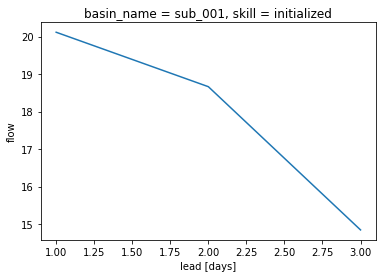

In [ ]:
verif.flow.plot()